1. Import the dataset

In [103]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime, timedelta
import yfinance as yf
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


In [104]:
ticker = "AAPL"   
start = "2024-01-01"
end = datetime.today().strftime("%Y-%m-%d")

df = yf.download(ticker, start=start, end=end, progress=False)
df.index = pd.to_datetime(df.index)

print(df.shape)
df.head()

(456, 5)


/var/folders/tt/n4r1gj3d491bnwkjhg289v4m0000gn/T/ipykernel_60707/1615775749.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.081482,186.857978,182.346174,185.578799,82488700
2024-01-03,182.703186,184.319507,181.890063,182.673439,58414500
2024-01-04,180.382812,181.552899,179.361461,180.620788,71983600
2024-01-05,179.658951,181.225688,178.657435,180.462163,62379700
2024-01-08,184.002167,184.041839,179.976254,180.561297,59144500


2. Preprocessing

In [105]:
# Missing values
missing_values = df.isnull().sum()
print(f"\n Missing values per column: {missing_values}")

if missing_values.sum() > 0:
    before_drop = len(df)
    df = df.dropna()
    after_drop = len(df)
    dropped_rows = before_drop - after_drop
    print(f"\n Dropped {dropped_rows} rows containing missing values.")

# Duplicates
duplicates_count = df.duplicated().sum()
print(f"\n Number of duplicate rows: {duplicates_count}")

# Drop duplicates if they exist
if duplicates_count > 0:
    df = df.drop_duplicates()
    print(f"\n Dropped {duplicates_count} duplicate rows.")

print(df.shape)


 Missing values per column: Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

 Number of duplicate rows: 0
(456, 5)


3. EDA

Price        Close        High         Low        Open        Volume
Ticker        AAPL        AAPL        AAPL        AAPL          AAPL
count   456.000000  456.000000  456.000000  456.000000  4.560000e+02
mean    213.431690  215.487285  211.135452  213.197435  5.662992e+07
std      24.478712   24.520750   24.202343   24.402125  2.782645e+07
min     163.823563  165.213575  162.910124  164.171055  2.241994e+07
25%     193.732079  196.069486  192.130472  193.521809  4.199435e+07
50%     216.838684  218.991164  214.443756  216.405850  4.932765e+07
75%     230.507504  232.396342  227.845839  230.156814  6.209425e+07
max     263.910004  265.290009  261.829987  262.649994  3.186799e+08
Price             Close      High       Low      Open    Volume
Ticker             AAPL      AAPL      AAPL      AAPL      AAPL
Price  Ticker                                                  
Close  AAPL    1.000000  0.996529  0.996023  0.991820 -0.210795
High   AAPL    0.996529  1.000000  0.993910  0.994932 

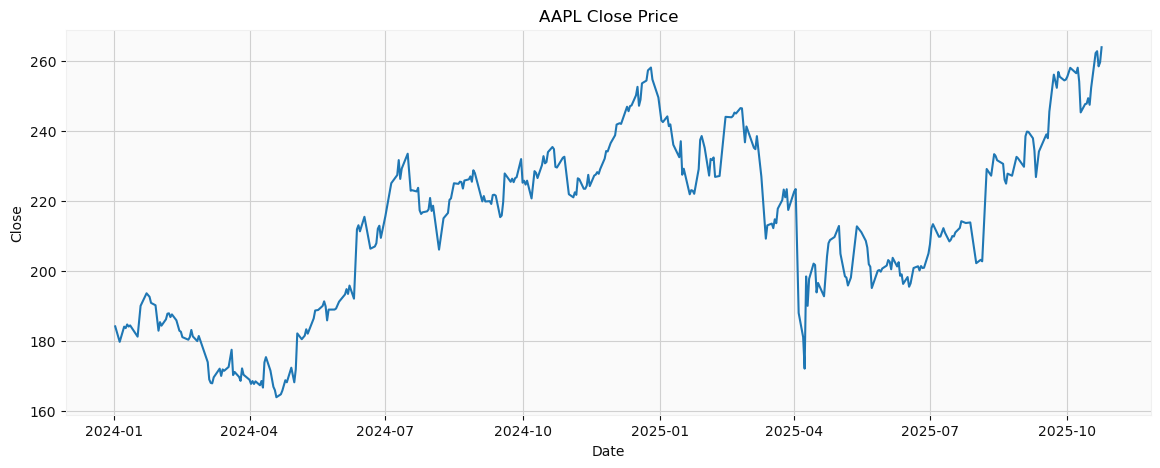

<Figure size 1400x500 with 0 Axes>

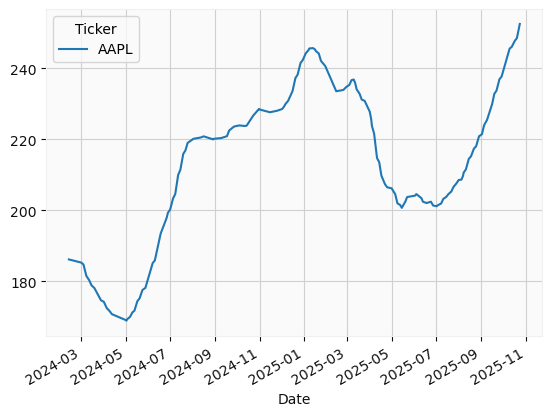

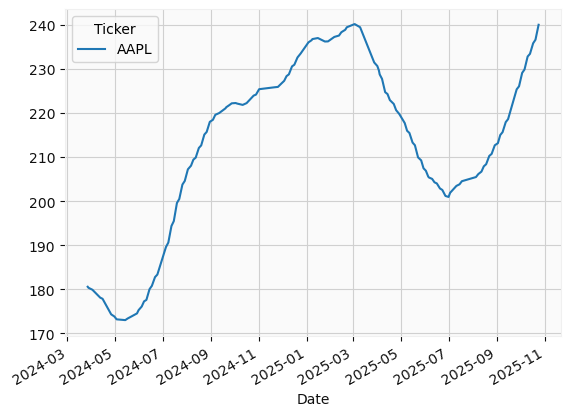

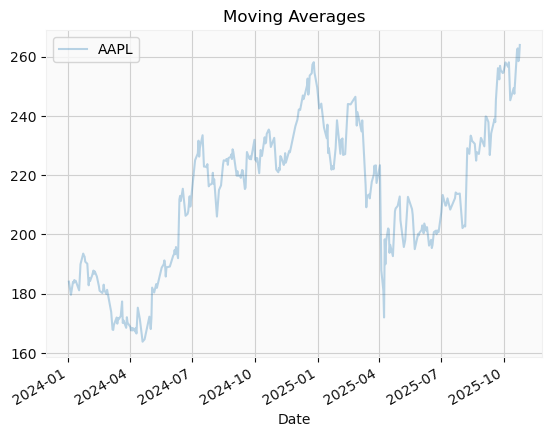

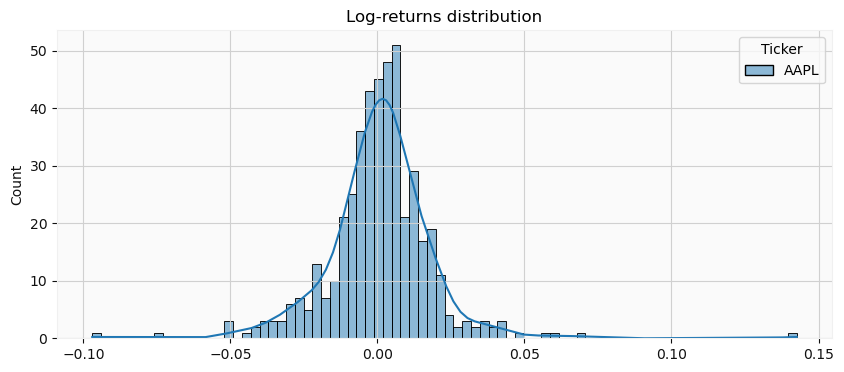

In [106]:
# Summary statistics
print(df.describe())

# Correlation matrix
print(df.corr())

series = df['Close'].copy()

# Simple plot
plt.figure(figsize=(14,5))
plt.plot(series.index, series.values)
plt.title(f"{ticker} Close Price")
plt.xlabel("Date"); plt.ylabel("Close")
plt.grid(True)
plt.show()

# Rolling statistics
plt.figure(figsize=(14,5))
series.rolling(30).mean().plot(label='30d MA')
series.rolling(60).mean().plot(label='60d MA')
series.plot(alpha=0.3, label='Close')
plt.legend(); plt.title("Moving Averages")
plt.show()

# Log returns distribution
returns = np.log(series).diff().dropna()
plt.figure(figsize=(10,4))
sb.histplot(returns, bins=80, kde=True)
plt.title("Log-returns distribution")
plt.show()

                 Close        High         Low        Open    Volume
Date                                                                
2024-01-02  184.081482  186.857978  182.346174  185.578799  82488700
2024-01-03  182.703186  184.319507  181.890063  182.673439  58414500
2024-01-04  180.382812  181.552899  179.361461  180.620788  71983600
2024-01-05  179.658951  181.225688  178.657435  180.462163  62379700
2024-01-08  184.002167  184.041839  179.976254  180.561297  59144500


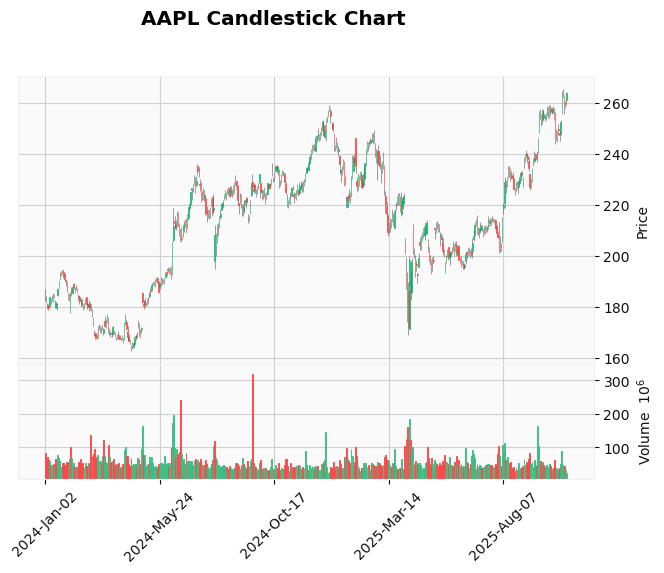

In [107]:
# EXTRA CANDLESTICK CHART
import mplfinance as mpf

df2 = df.copy()

# Flatten multi-level columns
df2.columns = [col[0] for col in df2.columns]

# Ensure Date is datetime index
df2.index = pd.to_datetime(df2.index)

# Sort by date (optional but good practice)
df2 = df2.sort_index()

# Verify final structure
print(df2.head())

mpf.plot(df2, type='candle', volume=True, title='AAPL Candlestick Chart', style='yahoo')

4. Feature Engineering

In [108]:
# Flatten the columns (keep just Price names)
df.columns = [col[0] for col in df.columns]

# Ensure index is datetime
df.index = pd.to_datetime(df.index)

# Sort by date
df = df.sort_index()


# 1. Lag Features
for lag in [1, 2, 3]: # 1-day, 2-day, 3-day
    for col in ['Open','High','Low','Close','Volume']:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)


# 2. Daily returns
df['Return'] = df['Close'].pct_change()

# Log returns (good for modeling)
import numpy as np
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))


# 3. Rolling windows
rolling_windows = [3, 7, 14] # 3-day, 7-day, 14-day

for window in rolling_windows:
    # Moving averages
    df[f"MA{window}"] = df['Close'].rolling(window).mean()
    
    # Rolling std (volatility)
    df[f"Volatility{window}"] = df['Close'].rolling(window).std()
    
    # Rolling max/min
    df[f"HighMax{window}"] = df['High'].rolling(window).max()
    df[f"LowMin{window}"] = df['Low'].rolling(window).min()


# 4. Day of the week (0=Monday, 6=Sunday)
df['DayOfWeek'] = df.index.dayofweek

# Month (1-12)
df['Month'] = df.index.month

# Is it end-of-week? (Friday)
df['IsFriday'] = (df.index.dayofweek == 4).astype(int)


# 5. Compute 14-day RSI 
def compute_RSI(series, window=14):
    """
    Compute the Relative Strength Index (RSI)
    
    series: pd.Series of closing prices
    window: lookback period (default 14)
    """
    delta = series.diff()
    
    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    # Compute rolling mean
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    
    # Relative Strength
    RS = avg_gain / avg_loss
    
    # RSI calculation
    RSI = 100 - (100 / (1 + RS))
    
    return RSI

df['RSI14'] = compute_RSI(df['Close'], window=14)

# Drop rows with NaN from lag/rolling/RSI calculations
df = df.dropna()
# print(df.head())
print(df.shape)

# Time-based split
# Define sizes
n = len(df)
train_size = int(0.7 * n)
val_size = int(0.15 * n)
test_size = n - train_size - val_size

# Split
train_df = df.iloc[:train_size]
val_df   = df.iloc[train_size:train_size+val_size]
test_df  = df.iloc[train_size+val_size:]

print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

# Features
X_train = train_df.drop(columns=['Return'])  # or 'Log_Return'
y_train = train_df['Return']

X_val   = val_df.drop(columns=['Return'])
y_val   = val_df['Return']

X_test  = test_df.drop(columns=['Return'])
y_test  = test_df['Return']

print("Train date range:", train_df.index.min(), "to", train_df.index.max())
print("Validation date range:", val_df.index.min(), "to", val_df.index.max())
print("Test date range:", test_df.index.min(), "to", test_df.index.max())



(442, 38)
Train shape: (309, 38)
Validation shape: (66, 38)
Test shape: (67, 38)
Train date range: 2024-01-23 00:00:00 to 2025-04-15 00:00:00
Validation date range: 2025-04-16 00:00:00 to 2025-07-22 00:00:00
Test date range: 2025-07-23 00:00:00 to 2025-10-24 00:00:00


5. Model

**Why XGBoost is a good choice here:**

*   Handles **non-linearities** (important in trading data).

*   Robust to **feature correlations** (lags, rolling stats).

*   Can handle **missing values** automatically.

*   Fast training on tabular data.

In [109]:
# Define and train the XGBoost model
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit the model
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    early_stopping_rounds=20,
    verbose=True
)

TypeError: XGBModel.fit() got an unexpected keyword argument 'eval_metric'

In [ ]:
print(xgb.__version__)


3.1.1
